In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [30]:
import numpy as np
import pandas as pd
import datetime as dt

In [31]:
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session


# Reflect Tables into SQLAlchemy ORM

In [32]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Column, Integer, Float, String, Date, func
from sqlalchemy.orm import sessionmaker


In [33]:
# Create engine using the `hawaii.sqlite` database file
#Connects to the SQLite db
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [34]:
# Declare a Base using `automap_base()
#Reflects tables into ORM Classes
Base = automap_base()

# Use the Base class to reflect the database tables
#Base.prepare(engine, reflect=True)
Base.prepare(autoload_with=engine)

In [35]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['measurement', 'station']


In [36]:
# Assign the measurement class to a variable called `Measurement` and
#Save references to the station and measurement tables 
Measurement = Base.classes.measurement
# the station class to a variable called `Station`
Station = Base.classes.station

In [37]:
# Create a session
Session = sessionmaker(bind=engine)
session = Session()

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.

# Step 4: Query for the most recent date
most_recent_str = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
print("Most Recent Date:", most_recent_str, type(most_recent_str))

Most Recent Date: 2017-08-23 <class 'str'>


In [39]:
# Check all columns mapped for the Measurement table
print(Measurement.__table__.columns.keys())

['id', 'station', 'date', 'prcp', 'tobs']


In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.

most_recent_date = dt.date.fromisoformat(most_recent_str)
print("Most Recent Date:", most_recent_date, type(most_recent_date))
year_ago_date = most_recent_date - dt.timedelta(days=365)
print(f"Date One Year Ago: {year_ago_date}")


# Perform a query to retrieve the data and precipitation scores

# Query precipitation data for the last 12 months
precipitation_data = (
    session.query(Measurement.date, func.avg(Measurement.prcp))
    .filter(Measurement.date > year_ago_date)
    .group_by(Measurement.date)
    .order_by(Measurement.date)
    .all()
)

# Print the first few rows of data
print(precipitation_data[:5])

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["date", "prcp"])

# Sort the dataframe by date
# Convert the 'date' column to datetime
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"])

# Print the first few rows of the DataFrame
print(precipitation_df.shape)
precipitation_df.head()



Most Recent Date: 2017-08-23 <class 'datetime.date'>
Date One Year Ago: 2016-08-23
[('2016-08-24', 1.555), ('2016-08-25', 0.07714285714285715), ('2016-08-26', 0.016666666666666666), ('2016-08-27', 0.064), ('2016-08-28', 0.5166666666666666)]
(365, 2)


,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667


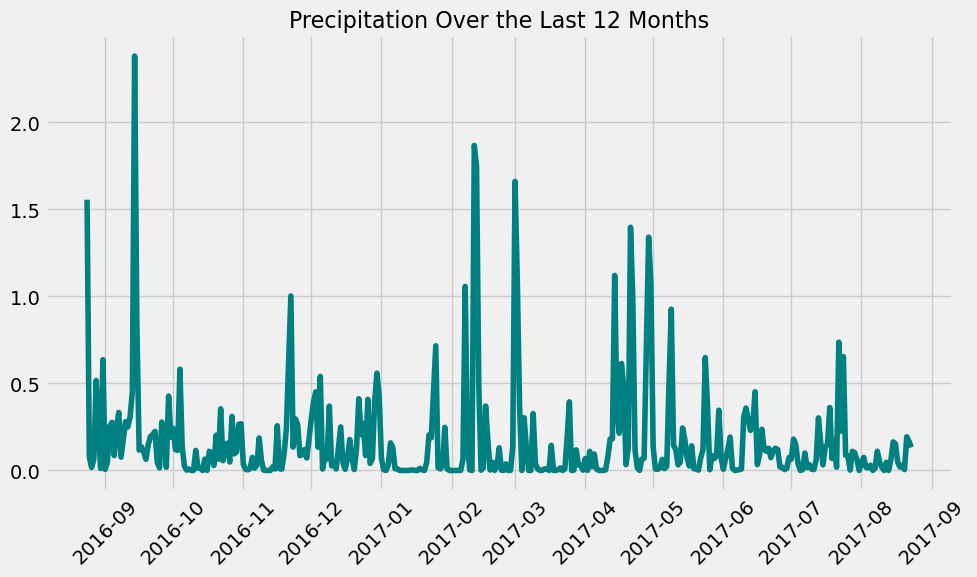

In [41]:
# Using Pandas Plotting with Matplotlib and plot the data
plt.figure(figsize=(10, 6))
plt.plot(precipitation_df["date"], precipitation_df["prcp"], linestyle='-', color='teal')
plt.title("Precipitation Over the Last 12 Months", fontsize=16)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.prcp.describe()

count    365.000000
mean       0.169987
std        0.295722
min        0.000000
25%        0.008571
50%        0.070000
75%        0.191667
max        2.380000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(most_active_stations)
most_active_station_id = most_active_stations[0][0]
most_active_station_id

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


'USC00519281'

In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station_id)
    .first()
)

print(f"Min Temp: {station_stats[0]}, Max Temp: {station_stats[1]}, Avg Temp: {station_stats[2]}")

Min Temp: 54.0, Max Temp: 85.0, Avg Temp: 71.66378066378067


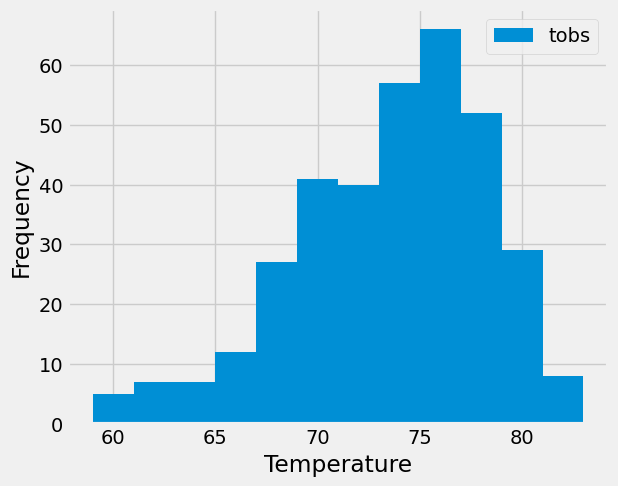

In [57]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > year_ago_date)\
    .order_by(Measurement.date)\
    .all()
    
df = pd.DataFrame(tobs_data, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")
plt.show()

# Close Session

In [58]:
# Close Session
session.close()
